# Setup Environment

In [13]:
%load_ext autoreload
import os
import sys
import requests
import pandas as pd
import janitor
import datamapplot

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
path_to_add = os.path.join(parent_dir, "src")
sys.path.insert(0, path_to_add)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\.venv\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Get Data

## Free text comments

In [110]:


# URL of the endpoint
url = "https://data.austintexas.gov/resource/jeyv-db9u.json"

# Fetch the data from the API
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(response.json()).clean_names()
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

## Questions data (likert)

In [ ]:
url_likert = "https://data.austintexas.gov/resource/s2py-ceb7.json"
data_dictionary_url = "https://data.austintexas.gov/api/views/s2py-ceb7/columns.json"

url = "https://data.austintexas.gov/dataset/Community-Survey/s2py-ceb7/about_data"

response = requests.get(url_likert)
if response.status_code == 200:
    # Convert the JSON data to a pandas DataFrame
    dfq = pd.DataFrame(response.json())
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

data_dictionary = requests.get(data_dictionary_url)
if response.status_code == 200:
    data_dictionary = data_dictionary.json()
else:
    print(f"Failed {response.status_code}")

In [9]:
dfl = pd.read_csv("../data/Community_Survey_20240911.csv").clean_names()

C:\Users\LONAL23\AppData\Local\Temp\ipykernel_36180\2967390319.py:1: DtypeWarning: Columns (7,9,10,12,13,14,15,16,17,18,19,20,21,25,30,31,32,36,37,38,39,42,43,44,62,63,64,65,73,80,83,85,86,87,88,89,90,91,92,93,94,95,96,99,100,104,111,113,114,115,116,117,118,119,123,124,125,126,127,128,129,135,136,137,144,145,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,172,173,189,190,191,192,193,199,200,201,204,205,209,212,213,214,215,216,217,218,219,220,223,233,234,235,236,237,238,239,241,243,244,245,246,247,248,249,250) have mixed types. Specify dtype option on import or set low_memory=False.
  dfl = pd.read_csv("../data/Community_Survey_20240911.csv").clean_names()


In [47]:
dfl.filter(like="council")

,council_district
0,1
1,1
2,3
3,4
4,1
...,...
10679,2
10680,4
10681,7
10682,5


In [30]:
likert_columns = ['the_city_of_austin_as_a_place_to_live',
       'the_city_of_austin_as_a_place_to_work',
       'the_city_of_austin_as_a_place_to_raise_children',
       'the_city_of_austin_as_a_place_to_retire',
       'the_city_of_austin_as_a_place_where_i_feel_welcome',
       'overall_quality_of_life_in_the_city',]

likert_columns_with_prefix = ["likert_encoded_" + col for col in likert_columns]


In [36]:
%autoreload 2
from pandas_survey_toolkit import analytics, nlp, vis
from pandas_survey_toolkit.vis import cluster_heatmap_plot


In [43]:
dfq2 = dfl.cluster_questions(likert_columns,hdbscan_min_cluster_size=50, cluster_selection_epsilon=0.4 )
print(f"Number of clusters: {dfq2.question_cluster_id.max()}")

Using default mapping:
-1: Phrases containing 'disagree', 'do not agree', etc.
 0: Phrases containing 'neutral', 'neither', 'unsure', etc.
+1: Phrases containing 'agree' (but not 'disagree' or 'not agree')
NaN: NaN values are preserved
  Neutral -> 0: 9687 times
  Very Satisfied -> 1: 13679 times
  Satisfied -> 1: 22358 times
  Dissatisfied -> -1: 5024 times
  Very Dissatisfied -> -1: 2437 times
  Don't Know -> 0: 4542 times
  nan -> <NA>: 6377 times
Number of clusters: 17.0


c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\.venv\Lib\site-packages\datamapplot\plot_rendering.py:49: UserWarning: Failed in getting google-font Arial; using fallback ...
  warn(f"Failed in getting google-font {fontname}; using fallback ...")


(<Figure size 1200x1200 with 1 Axes>, <Axes: >)

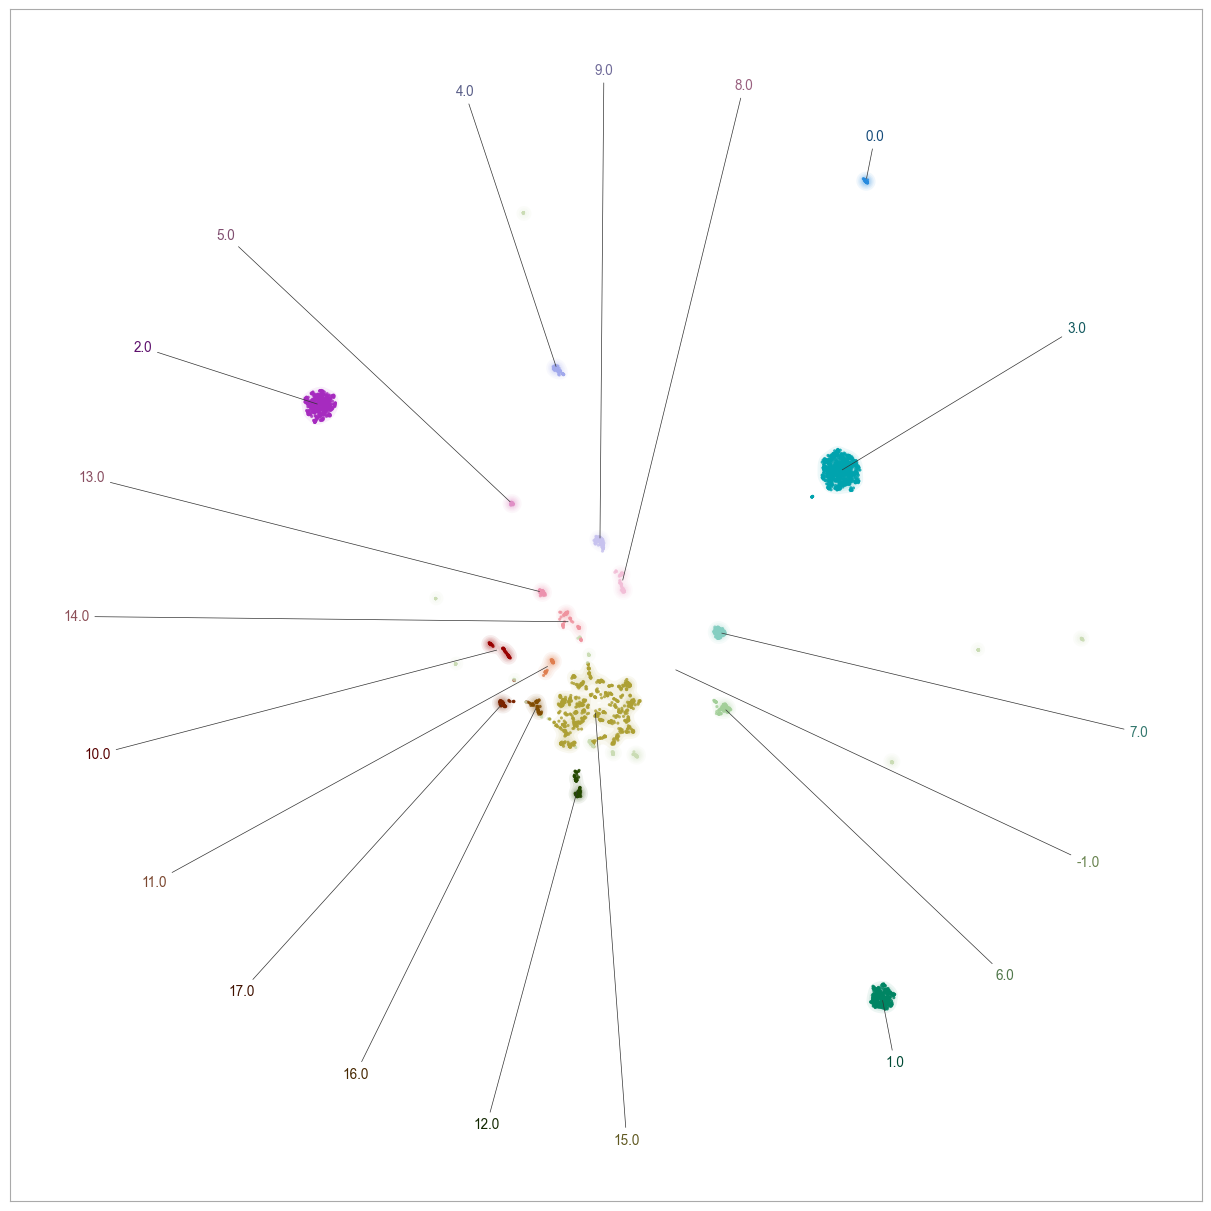

In [44]:
datamapplot.create_plot(dfq2[['likert_umap_x', 'likert_umap_y']].dropna().values, dfq2['question_cluster_id'].dropna().astype(str).values, noise_label=-1, font_family="Arial")

In [45]:
cluster_heatmap_plot(dfq2, x="question_cluster_id", y = likert_columns_with_prefix)

alt.VConcatChart(...)

In [59]:
df_plot = dfq2.groupby(["council_district", "question_cluster_id"]).agg({"id" : "count"})

In [63]:
df_plot = df_plot.reset_index()

In [65]:
df_plot

,council_district,question_cluster_id,id
0,1,-1.0,29
1,1,0.0,8
2,1,1.0,50
3,1,2.0,38
4,1,3.0,72
...,...,...,...
185,10,13.0,18
186,10,14.0,12
187,10,15.0,76
188,10,16.0,11


In [66]:
# Create heatmap
import altair as alt
heatmap = alt.Chart(df_plot).mark_rect().encode(
    x=alt.X(f'question_cluster_id:O', title='Cluster ID'),
    y=alt.Y('council_district:O', title=None),
    color=alt.Color('id:Q'))

heatmap


alt.Chart(...)

In [ ]:
dfq.to_excel('austin_likert.xlsx')

In [126]:
%autoreload 2
from pandas_survey_toolkit import analytics, nlp, vis
from pandas_survey_toolkit.vis import create_keyword_graph, visualize_keyword_graph,visualize_keyword_graph_force, create_keyword_sentiment_df_simple, create_sentiment_color_mapping

In [127]:
df2 = df.extract_keywords("response", top_n=4, ngram_range=(1,1), min_df=5, min_proportion_with_keywords=0.85)

Refinement complete. Min count used: 5
Original average keywords per row: 2.02
Refined average keywords per row: 1.90
Proportion of rows with keywords after refinement: 85.03%
Total unique keywords before refinement: 367
Total unique keywords after refinement: 123
Reduction in unique keywords: 66.49%


In [124]:
df2.refined_keywords.map(lambda x : len(x) > 0).mean()

c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\src\pandas_survey_toolkit\nlp.py:22: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'cluster_questions' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def cluster_questions(df, columns=None, pattern=None, likert_mapping=None,
c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\src\pandas_survey_toolkit\nlp.py:70: UserWarning: registration of accessor <class 'pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod'> under name 'encode_likert' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  def encode_likert(df, likert_columns, output_prefix='likert_encoded_', custom_mapping=None, debug=True):
c:\Users\LONAL23\OneDriv

0.8503480278422274

In [128]:
df2 = df2.extract_sentiment("response")

c:\Users\LONAL23\OneDrive - PA Consulting Group\7 - Data Scientist\pandas-survey-toolkit\.venv\Lib\site-packages\transformers\modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this ex

In [ ]:
import datamapplot

In [ ]:
def collect_unique_keywords(df, group_column, keyword_column):
    # Define a function to convert list to set and combine sets
    def combine_keywords(series):
        return set().union(*[set(keywords) for keywords in series if isinstance(keywords, list)])
    
    # Group by the specified column and aggregate keywords
    grouped = df.groupby(group_column)[keyword_column].agg(combine_keywords).reset_index()
    
    # Rename the aggregated column
    grouped = grouped.rename(columns={keyword_column: f'unique_{keyword_column}'})
    
    return grouped

df_labels = collect_unique_keywords(df2, "cluster", "refined_keywords")

In [ ]:
df2 = df2.merge(df_labels, on="cluster")

In [ ]:
df2["labels"] = df2["unique_refined_keywords"].map(lambda x: "-".join(x))

In [ ]:
import numpy as np


datamapplot.create_plot(df2[['umap_x', 'umap_y']].values, df2["labels"].values,)# hover_text =df2["response"].values )

In [129]:
sentiment_df = create_keyword_sentiment_df_simple(df2)
sentiment_df = sentiment_df.query("word != 'not'")
color_mapping = create_sentiment_color_mapping(sentiment_df)

G = create_keyword_graph(df2, 'keywords', node_color_mapping=color_mapping)
G.remove_node("not")
visualize_keyword_graph_force(G, output_file='keyword_sentiment_graph.html', colormap='RdBu', min_edge_count=2, min_node_count=1)

Graph saved to keyword_sentiment_graph.html
